In [ ]:
from __future__ import print_function
from __future__ import division

import math
import copy
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, invert_permutation
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
assert torch.cuda.is_available(), 'GPU unavailable'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ML_final_project/labeled_log-madbench_reformat.csv", header = None)
data = data.T.to_numpy()[1:6,:]
print(data)
window = 100
data = np.hsplit(data, data.shape[1] / window)
print(len(data))

[[2.51030000e+04 2.51060000e+04 2.51070000e+04 ... 2.51040000e+04
  2.51040000e+04 2.51040000e+04]
 [1.20000000e+01 8.00000000e+00 8.00000000e+00 ... 1.00000000e+01
  1.00000000e+01 1.00000000e+01]
 [1.35168000e+05 1.35168000e+05 1.35168000e+05 ... 6.68368896e+08
  6.68401664e+08 6.68434432e+08]
 [4.09600000e+03 4.09600000e+03 4.09600000e+03 ... 4.09600000e+03
  4.09600000e+03 4.09600000e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
52427


In [ ]:
def get_data_loader(data, batch_size):
  random.shuffle(data)
  data = np.array(data)
  source_seq = data[:,:4,:]
  target_seq = data[:,4:,:]

  source_seq = torch.LongTensor(source_seq)
 
  target_seq = torch.LongTensor(target_seq)
 
  source_seq = source_seq.permute(0,2,1) #num_samples, seq_len, embedding_dim 
  target_seq = target_seq.permute(0,2,1) #num_samples, seq_len, 1 
  train_set_size = int(0.9 * len(source_seq))

  
  train_set = TensorDataset(
    source_seq[:train_set_size],
    target_seq[:train_set_size])
  
  val_set = TensorDataset(
    source_seq[train_set_size:],
    target_seq[train_set_size:])
  
  loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }

  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)

  return source_seq, target_seq, train_loader, val_loader

In [ ]:
source_data, target_data, train_loader, val_loader = get_data_loader(
  data, batch_size=40)
print('source_data size:', source_data.size)
print('target_data size:', target_data.size)

print(source_data.shape)
print(target_data.shape)

source_data size: <built-in method size of Tensor object at 0x7f1ef66b7cd0>
target_data size: <built-in method size of Tensor object at 0x7f1ef5342b90>
torch.Size([52427, 100, 4])
torch.Size([52427, 100, 1])


In [ ]:
source_seq,target_seq, train_loader, val_loader = get_data_loader(data, batch_size=100)

In [ ]:
class MultiHeadCausalSelfAttention(nn.Module):
  
  def __init__(self, d_model, num_heads, dropout=0.):
    super().__init__()
    
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.d_model = d_model
    self.num_heads = num_heads
    
    # This dropout is to be applied to the attention weights
    # immediately after the softmax. It was not mentioned
    # in the paper, but is used in the actual implementation.
    self.dropout = nn.Dropout(dropout)
    
    # The weight matrices of all heads are concatenated together
    self.proj_q = nn.Linear(d_model, d_model, bias=False)
    self.proj_k = nn.Linear(d_model, d_model, bias=False)
    self.proj_v = nn.Linear(d_model, d_model, bias=False)
    
    self.proj_o = nn.Linear(d_model, d_model, bias=False)

  
  def forward(self, input):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, seq_len, d_model)
      containing sequences of embeddings.
    
    Returns:
    - output: A Tensor of shape (batch_size, seq_len, d_model)
      containing the updated embeddings.
    """
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass. No for loop is allowed.                   #
    # You may not use PyTorch's built-in multi-head attention.              #
    #########################################################################
    # Replace "pass" statement with your code
    dk = torch.div(self.d_model,self.num_heads,rounding_mode="trunc")
  
    dv  = dk
    bs,sl ,_ = input.shape

    
    #split projection matrixes into h heads for parallel computation after projection
    Q_concat = self.proj_q(input).view(bs,-1,self.num_heads,dk).transpose(1,2) #shape (bs,num_heads,seq_len,dk)
    K_concat = self.proj_k(input).view(bs,-1,self.num_heads,dk).transpose(1,2)
    V_concat = self.proj_v(input).view(bs,-1,self.num_heads,dv).transpose(1,2)
    
    #scaled dot-product attention to obtain raw scores
    raw_score = torch.matmul(Q_concat, K_concat.transpose(-2,-1))/math.sqrt(dk)  #resulting shape (bs,num_heads,sl,sl)
    # mask
    attn_mask = torch.triu(
    input.new_ones((sl, sl), dtype=torch.bool),
    diagonal=1)
    attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)#view(bs, self.num_heads,sl,sl)
    raw_score = raw_score.masked_fill(attn_mask == 1, -1e9)

    #softmax 
    score = self.dropout(torch.softmax(raw_score, dim = -1))
    
    multihead_v = torch.matmul(score,V_concat) # resulting shape (bs,num_heads,sl,dv)
    multihead_v = multihead_v.transpose(1,2).contiguous().view(bs,-1,self.d_model)  #(bs,sl,num_heads*dv)
    output = self.proj_o(multihead_v)
    


    # END OF YOUR CODE
    return output

In [ ]:
class TransformerBlock(nn.Module):
  
  def __init__(self, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.mulHeadAtt = MultiHeadCausalSelfAttention(d_model = d_model,num_heads= num_heads, dropout = dropout)
    self.feedForward1 = nn.Linear(d_model,d_ff)
    self.relu = nn.ReLU()
    self.feedForward2 = nn.Linear(d_ff,d_model) 
    self.layerNorm = nn.LayerNorm(d_model)
  
  
  def forward(self, input):
    x = input
    output = self.mulHeadAtt(input)  # multihead causal self-attention  
    output = self.dropout(output)  # dropout 
    output = output + x  # residual connection 
    output = self.layerNorm(output) # layer normalization 
    x = output 
    output = self.feedForward1(output)
    output = self.relu(output)
    output = self.feedForward2(output)

    output = self.dropout(output)
    output = x + output  
    output = self.layerNorm(output)
    return output

In [ ]:
class PositionalEncoding(nn.Module):
  
  def __init__(self, max_len, d_model, dropout=0.):
    super().__init__()
    
    self.dropout = nn.Dropout(dropout)
    pos = torch.arange(max_len).unsqueeze(1).repeat(1,d_model)
    #print("pos shape: ",pos.shape,"max_len",max_len)
    assert pos.shape == torch.Size([max_len,d_model])
    dim = torch.pow(10 , torch.arange(d_model)/d_model )
    pe = pos / dim 
    pe[0::2] = torch.sin(pe[0::2])
    pe[1::2] = torch.cos(pe[1::2])

    pe = pe.unsqueeze(0)
    self.register_buffer('pe',pe)

  def forward(self, input):
    bs, seq_len,d_model = input.shape
    input = input*math.sqrt(d_model)
    output = input + Variable(self.pe[:,:seq_len],requires_grad= False).cuda()

    return output

In [ ]:
class Transformer(nn.Module): # without embedding
  
  def __init__(self, num_blocks, label_classes, max_len, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()

    self.d_model = d_model
    self.label_classes = label_classes
    self.num_heads = num_heads
    self.d_ff = d_ff
    self.max_len = max_len
    self.num_blocks = num_blocks 
    self.PE = PositionalEncoding(max_len = max_len, d_model = d_model,dropout = dropout)
    self.emd = nn.Embedding(label_classes, d_model,padding_idx = 0)
    self.fullyConnect = nn.Linear(d_model,label_classes)
    self.blocks = nn.ModuleList([TransformerBlock(d_model,num_heads,d_ff,dropout) for _ in range(num_blocks)])
    #self.feedForward1 = nn.Linear(d_model,d_ff)
    #self.relu = nn.ReLU()
    #self.feedForward2 = nn.Linear(d_ff,label_classes)
    
  def forward(self, input,target):
    PE_input = self.PE(input)
    for i in range(num_blocks):
      transBlock = self.blocks[i]
      PE_input = transBlock(PE_input)
    #  print("passed first transblock") 
    
    pred = self.fullyConnect(PE_input)
    
    #pred = self.fullyConnect(pred)  # bs,sel,vocab_size  raw output
    target.squeeze(-1)
    
   # print(pred.shape)
    target = target.squeeze()
   # print(target.shape)
    #print("visited")
    #weight = torch.cuda.FloatTensor([1,5])
    CE = torch.nn.CrossEntropyLoss()
    loss = CE(pred.reshape(-1,self.label_classes), target.reshape(-1))
    return loss
  
  
  def predict(self, input):
    PE_input = self.PE(input)
    for i in range(num_blocks):
      transBlock = self.blocks[i]
      PE_input = transBlock(PE_input)
    # print("passed first transblock")
   
    #output = self.feedForward1(PE_input)
    #output = self.relu(output)
    #pred = self.feedForward2(output) #out shape(bs,seq_len,voc_size) 
    pred = self.fullyConnect(PE_input)
    pred = torch.argmax(pred, dim =2).squeeze()  # out shape (bs,seq_len,1)
    # print("prediction shape: ", pred.shape)

    return pred

In [ ]:
def eval_acc(model, data_loader, num_samples=5):
  
  with torch.no_grad():
    model.eval()
    
    
    total = 0
    correct = 0
    totalPositive = 0 
    totalFalsePositive = 0
    for batch, data in enumerate(data_loader):
      data = [d.cuda() for d in data] # a data point consists of batches of input (bs, seq_len, d_model)and target (bs,seq_len,1)
      
    
      pred = model.predict(data[0])
      target = data[1]
      #if batch < num_samples:  # show some samples
        #target_sentence = [target_vocab.index2word[token] for token in data[0][0].tolist()]
        #pred_sentence = [target_vocab.index2word[token] for token in pred[0].tolist()]
        
        #print(f'=== Sample {batch + 1} ===')
        #print('target_sentence:', target_sentence)
        #print('pred_sentence:  ', pred_sentence)
      
      total += target.view(-1).shape[0]
      #num_of_ones = torch.count_nonzero(target.view(-1), dim=0)
      
      target = target.squeeze()
      correct += (target == pred ).sum()
      positive = pred[target ==1] 
      falsePositive = len(positive) - torch.count_nonzero(positive)
      totalPositive += len(positive)
      totalFalsePositive += falsePositive
    #print("correct: ",correct)
    #print("total: ", total)
    acc = 100 * correct / total
    #print(acc)
    falsePositiveRate = totalFalsePositive/totalPositive
    print("false Positive Rate is: ", falsePositiveRate.item())
  return acc.item()

In [ ]:
def train(model, train_loader, val_loader, num_epochs, learning_rate):
  
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  loss_history = []
 

  for epoch in range(num_epochs):
    val_acc = eval_acc(model, val_loader, num_samples=0)
    
    model.train()
    for batch, data in enumerate(train_loader):
      data = [d.cuda() for d in data]
      
      optimizer.zero_grad()
      loss = model(*data)
      loss.backward()
      clip_grad_norm_(model.parameters(), 1)  # gradient clipping
      optimizer.step()
      
      with torch.no_grad():
        loss_history.append(loss.item())
        if batch == 0:
          print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
            epoch, loss.item(), val_acc))
  

  return model, loss_history

In [ ]:
torch.manual_seed(1)

batch_size = 80
num_epochs = 50
learning_rate = 1e-4
#5e-4 78%

num_blocks = 1
d_model = 4
num_heads = 1
d_ff = 4 * d_model
dropout = 0.3

label_classes = 2 
MAX_LEN = 100

source_seq,target_seq, train_loader, val_loader = get_data_loader(data, batch_size)
model = Transformer(num_blocks, label_classes, MAX_LEN, d_model, num_heads, d_ff, dropout)
model = model.cuda()

import time

start = time.time()
model, loss_history = train(model, train_loader, val_loader, num_epochs, learning_rate)
end = time.time()
print(end - start)
print((end - start)/20)

false Positive Rate is:  0.9616823792457581
Train Epoch:   0 	 Loss: 0.764503 	 Val Acc: 10.546731
false Positive Rate is:  0.0
Train Epoch:   1 	 Loss: 0.580147 	 Val Acc: 92.788467
false Positive Rate is:  0.0
Train Epoch:   2 	 Loss: 0.427688 	 Val Acc: 92.772499
false Positive Rate is:  0.0
Train Epoch:   3 	 Loss: 0.333148 	 Val Acc: 92.773659
false Positive Rate is:  0.0
Train Epoch:   4 	 Loss: 0.293682 	 Val Acc: 92.771156
false Positive Rate is:  0.0
Train Epoch:   5 	 Loss: 0.250782 	 Val Acc: 92.785774
false Positive Rate is:  0.0
Train Epoch:   6 	 Loss: 0.275892 	 Val Acc: 92.787308
false Positive Rate is:  0.0
Train Epoch:   7 	 Loss: 0.281274 	 Val Acc: 92.783272
false Positive Rate is:  0.0
Train Epoch:   8 	 Loss: 0.272505 	 Val Acc: 92.822121
false Positive Rate is:  0.0
Train Epoch:   9 	 Loss: 0.246748 	 Val Acc: 92.803848
false Positive Rate is:  0.0
Train Epoch:  10 	 Loss: 0.245301 	 Val Acc: 92.783081
false Positive Rate is:  0.0
Train Epoch:  11 	 Loss: 0.23716

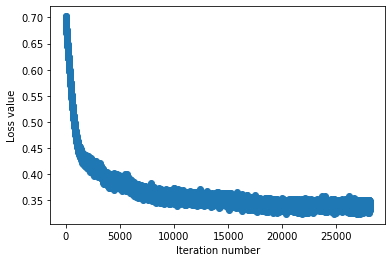

In [ ]:
plt.plot(loss_history, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

false Positive Rate is:  5.009726373828016e-05
Training Accuracy: 52.39163589477539


In [ ]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)
assert val_acc >= 38

false Positive Rate is:  6.914991536177695e-05
Validation Accuracy: 52.48508071899414


In [ ]:
model

Transformer(
  (PE): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (emd): Embedding(2, 4, padding_idx=0)
  (fullyConnect): Linear(in_features=4, out_features=2, bias=True)
  (blocks): ModuleList(
    (0): TransformerBlock(
      (dropout): Dropout(p=0.3, inplace=False)
      (mulHeadAtt): MultiHeadCausalSelfAttention(
        (dropout): Dropout(p=0.3, inplace=False)
        (proj_q): Linear(in_features=4, out_features=4, bias=False)
        (proj_k): Linear(in_features=4, out_features=4, bias=False)
        (proj_v): Linear(in_features=4, out_features=4, bias=False)
        (proj_o): Linear(in_features=4, out_features=4, bias=False)
      )
      (feedForward1): Linear(in_features=4, out_features=16, bias=True)
      (relu): ReLU()
      (feedForward2): Linear(in_features=16, out_features=4, bias=True)
      (layerNorm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [ ]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.4519, -0.1661, -1.5228,  0.3817]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 0.3437,  0.6721,  0.3051, -0.2518],
        [-0.4575, -0.9761,  0.0482,  0.1917]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.6851,  0.5488], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.2981,  0.2718, -0.4888,  0.3100],
        [ 0.1397,  0.4743,  0.3300, -0.4556],
        [-0.4754, -0.2412,  0.4391, -0.0833],
        [ 0.2140, -0.2324,  0.4906, -0.2115]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 0.3750,  0.0059, -0.2634,  0.2570],
        [-0.2654,  0.1471, -0.1444, -0.0548],
        [-0.4807, -0.2384,  0.2713, -0.1215],
        [ 0.4980,  0.4008, -0.0234, -0.3337]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.1179, -0.4499, -0.2774, -0.0596],
        [ 1.0474,  1.2953,

In [ ]:
i = 0
for param in model.parameters():
  i = i + 1
  if i == 2:
    print(param)

Parameter containing:
tensor([[ 0.3437,  0.6721,  0.3051, -0.2518],
        [-0.4575, -0.9761,  0.0482,  0.1917]], device='cuda:0',
       requires_grad=True)


In [ ]:
i = 0
for param in model.parameters():
  i = i + 1
  if i != 2:
    param.requires_grad = False

for param in model.parameters():
  print(param)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.4519, -0.1661, -1.5228,  0.3817]], device='cuda:0')
Parameter containing:
tensor([[ 0.3437,  0.6721,  0.3051, -0.2518],
        [-0.4575, -0.9761,  0.0482,  0.1917]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.6851,  0.5488], device='cuda:0')
Parameter containing:
tensor([[ 0.2981,  0.2718, -0.4888,  0.3100],
        [ 0.1397,  0.4743,  0.3300, -0.4556],
        [-0.4754, -0.2412,  0.4391, -0.0833],
        [ 0.2140, -0.2324,  0.4906, -0.2115]], device='cuda:0')
Parameter containing:
tensor([[ 0.3750,  0.0059, -0.2634,  0.2570],
        [-0.2654,  0.1471, -0.1444, -0.0548],
        [-0.4807, -0.2384,  0.2713, -0.1215],
        [ 0.4980,  0.4008, -0.0234, -0.3337]], device='cuda:0')
Parameter containing:
tensor([[-0.1179, -0.4499, -0.2774, -0.0596],
        [ 1.0474,  1.2953, -0.3747,  0.6117],
        [-0.9368, -0.8702, -0.2733, -1.1846],
        [-0.0218, -0.3942,  0.2557,

In [ ]:
model_transfer = copy.deepcopy(model)
model_transfer = model_transfer.cuda()

In [ ]:
for param in model_transfer.parameters():
  print(param)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.4519, -0.1661, -1.5228,  0.3817]], device='cuda:0')
Parameter containing:
tensor([[ 0.3437,  0.6721,  0.3051, -0.2518],
        [-0.4575, -0.9761,  0.0482,  0.1917]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.6851,  0.5488], device='cuda:0')
Parameter containing:
tensor([[ 0.2981,  0.2718, -0.4888,  0.3100],
        [ 0.1397,  0.4743,  0.3300, -0.4556],
        [-0.4754, -0.2412,  0.4391, -0.0833],
        [ 0.2140, -0.2324,  0.4906, -0.2115]], device='cuda:0')
Parameter containing:
tensor([[ 0.3750,  0.0059, -0.2634,  0.2570],
        [-0.2654,  0.1471, -0.1444, -0.0548],
        [-0.4807, -0.2384,  0.2713, -0.1215],
        [ 0.4980,  0.4008, -0.0234, -0.3337]], device='cuda:0')
Parameter containing:
tensor([[-0.1179, -0.4499, -0.2774, -0.0596],
        [ 1.0474,  1.2953, -0.3747,  0.6117],
        [-0.9368, -0.8702, -0.2733, -1.1846],
        [-0.0218, -0.3942,  0.2557,

In [ ]:
new_data = pd.read_csv("/content/drive/MyDrive/ML_final_project/rand_reuse_str-1_files-10_ent-500k_labeled.csv", header = None)
new_data = new_data.T.to_numpy()[1:6,:]
window = 100
new_data = np.hsplit(new_data, new_data.shape[1] / window)
new_source_seq,new_target_seq, new_train_loader, new_val_loader = get_data_loader(new_data, batch_size=100)
print(new_source_seq.shape)
print(new_target_seq.shape)

torch.Size([49998, 100, 4])
torch.Size([49998, 100, 1])


In [ ]:
torch.manual_seed(0)

batch_size = 80
num_epochs = 20
learning_rate = 5e-5


num_blocks = 1
d_model = 4
num_heads = 1
d_ff = 4 * d_model
dropout = 0.3

label_classes = 2 
MAX_LEN = 100

new_source_seq, new_target_seq, new_train_loader, new_val_loader = get_data_loader(new_data, batch_size)

model_transfer, loss_history = train(model_transfer, new_train_loader, new_val_loader, num_epochs, learning_rate)

false Positive Rate is:  3.205068060196936e-05
Train Epoch:   0 	 Loss: 0.161744 	 Val Acc: 75.484474
false Positive Rate is:  3.20508552249521e-05
Train Epoch:   1 	 Loss: 0.164496 	 Val Acc: 75.484070
false Positive Rate is:  3.204683162039146e-05
Train Epoch:   2 	 Loss: 0.159868 	 Val Acc: 75.493546
false Positive Rate is:  3.2044521503848955e-05
Train Epoch:   3 	 Loss: 0.155554 	 Val Acc: 75.498993
false Positive Rate is:  3.204366294085048e-05
Train Epoch:   4 	 Loss: 0.159463 	 Val Acc: 75.500801
false Positive Rate is:  3.204435051884502e-05
Train Epoch:   5 	 Loss: 0.162337 	 Val Acc: 75.499191
false Positive Rate is:  2.9375947633525357e-05
Train Epoch:   6 	 Loss: 0.158812 	 Val Acc: 75.494354
false Positive Rate is:  2.670726098585874e-05
Train Epoch:   7 	 Loss: 0.157483 	 Val Acc: 75.489311
false Positive Rate is:  2.4037626644712873e-05
Train Epoch:   8 	 Loss: 0.158042 	 Val Acc: 75.486084
false Positive Rate is:  2.403223334113136e-05
Train Epoch:   9 	 Loss: 0.153126

In [ ]:
for batch, data in enumerate(new_val_loader):
  data = [d.cuda() for d in data]
  target = data[1]
  pred = model.predict(data[0])
  pred_new = model_transfer.predict(data[0])
print(target)

tensor([[[1],
         [1],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [0],
         ...,
         [0],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1],
         [1],
         [1],
         ...,
         [0],
         [1],
         [1]],

        [[0],
         [1],
         [1],
         ...,
         [0],
         [1],
         [1]],

        [[1],
         [0],
         [1],
         ...,
         [1],
         [1],
         [1]]], device='cuda:0')
